In [6]:
import warnings
warnings.filterwarnings('ignore')
import os, shutil,gc
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.models import load_model,Sequential
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score

# Loading Data

In [7]:
train=pd.read_csv('C:/Users/reya.sadhu/Downloads/train.csv')
test=pd.read_csv('C:/Users/reya.sadhu/Downloads/test.csv')

In [8]:
train.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [9]:
test.head()

,image_name
0,3.jpg
1,5.jpg
2,6.jpg
3,11.jpg
4,14.jpg


# EDA

In [5]:
train[train.isnull().any(axis=1)]

,image_name,label


So, there is no null values.

In [22]:
scene={0:'Building',1:'Forest',2:'Glacier',3:'Mountain',4:'Sea',5:'Street'}
train['scene']=train['label'].map(scene).astype('category')

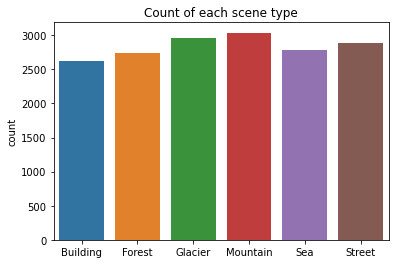

In [7]:
plt.title('Count of each scene type')
sns.countplot(train['scene'].values)
plt.show()

In [8]:
train['scene'].value_counts(normalize=True)

Mountain    0.178290
Glacier     0.173594
Street      0.169250
Sea         0.163438
Forest      0.161148
Building    0.154280
Name: scene, dtype: float64

So, there are equal proportions of data in each category. So, no class imbalance problem.

# Preprocessing

There are 6 different labels. So, we need to hot encode the labels.

In [10]:
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder(dtype='int8',sparse=False)
y=encoder.fit_transform(train['label'].values.reshape(-1,1))

In [10]:
y.shape

(17034, 6)

In [11]:
y[0]

array([1, 0, 0, 0, 0, 0], dtype=int8)

# Loading images

We need to reshape each iamge to a particular size before feeding it into the network. Here we choose the shape (224,224). We also need to normalize the pixel value so that they have value in between 0-1. The pixel values of RGB image lies from 0 to 255. So, we divide each pixel value by 255. 

In [11]:
path='C:/Users/reya.sadhu/Downloads/images'
def load_and_process(what):
    imgs = []
    if what =='train':
        for file in tqdm(train['image_name'].values):
            img = load_img(os.path.join(path, file), target_size=(224,224))
            img = img_to_array(img)/255.
            imgs.append(img)
    elif what =='test':
        for file in tqdm(test['image_name'].values):
            img = load_img(os.path.join(path, file), target_size=(224,224))
            img = img_to_array(img)/255. 
            imgs.append(img)
    gc.collect()
    return np.asarray(imgs)

In [12]:
train_imgs = load_and_process('train')
test_imgs = load_and_process('test')
print(f'train shape: {train_imgs.shape}')
print(f'test shape: {test_imgs.shape}')

100%|█████████████████████████████████████████████████████████████████████████████| 7301/7301 [00:21<00:00, 340.59it/s]


train shape: (17034, 224, 224, 3)
test shape: (7301, 224, 224, 3)


# Visualizing images

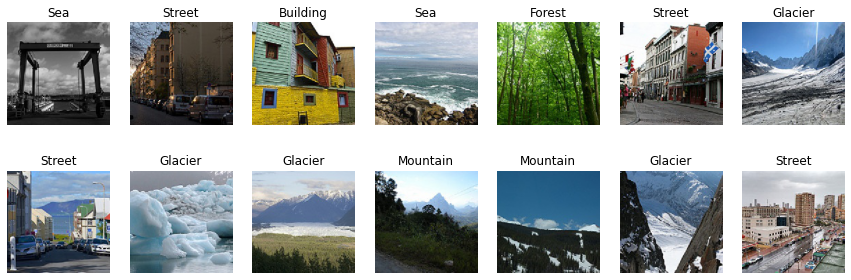

30206

In [19]:
plt.figure(figsize=(15,5))

for i in range(1,15):
    plt.subplot(2,7,i)
    plt.title(f'{train["scene"].values[i]}')
    plt.imshow(train_imgs[i])
    plt.axis('off')
plt.show()
gc.collect()

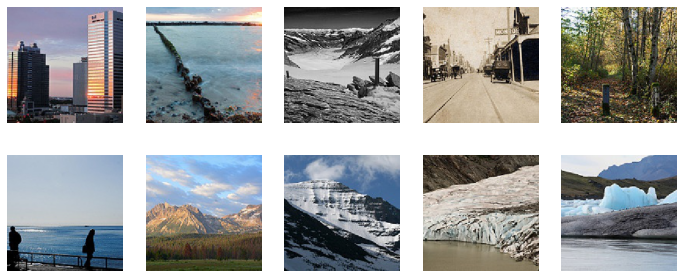

21621

In [20]:
plt.figure(figsize=(12,5))

for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(test_imgs[i])
    plt.axis('off')
plt.show()
gc.collect()

So, as seen from the images, there are four groups which can be confusing. The street and building groups, since some street photos also have a portion and building. And for the same reason, the glacier and mountain photos.

Since we have a large dataset for training, we can drop some of these confusing images. So, we take a pretrained model, run it for a very few epochs, and check the probability for each image. The images with probability less than 0.55 are dropped.

# Train the whole data 

## Data augmentation

In [21]:
BS = 32
gen = ImageDataGenerator(rotation_range=45, 
                         horizontal_flip=True, 
                         width_shift_range=0.5, 
                         height_shift_range=0.5)

train_generator = gen.flow(train_imgs, y,batch_size=BS)

In [23]:
from tensorflow.keras.applications.xception import Xception
model_init=models.Sequential([
    layers.Input((224,224,3)),
    Xception(include_top=False),
    GlobalAveragePooling2D(),
    Dense(6, activation='softmax')
])

In [24]:
lr=0.0001
epoch=2
model_init.compile(loss='categorical_crossentropy', 
              metrics=['accuracy'],
              optimizer=Adam(lr=lr,decay=lr/20))

In [26]:
history_init = model_init.fit_generator(train_generator, 
                    steps_per_epoch=len(train_imgs)//BS, 
                    epochs=epoch)

Epoch 1/2
532/532 [==============================] - 5093s 10s/step - loss: 0.4527 - accuracy: 0.8416
Epoch 2/2
532/532 [==============================] - 5224s 10s/step - loss: 0.2818 - accuracy: 0.8986


# Drop the confusing images

In [27]:
prob=np.max(model_init.predict(train_imgs),axis=1)
prob

array([0.76567006, 0.7710076 , 0.8762697 , ..., 0.9849274 , 0.99929345,
       0.99016994], dtype=float32)

In [28]:
index=[]
for i in range(prob.shape[0]):
    if prob[i]<0.55:
        index.append(i)

In [29]:
len(index)

327

# Visualizing the confusing images

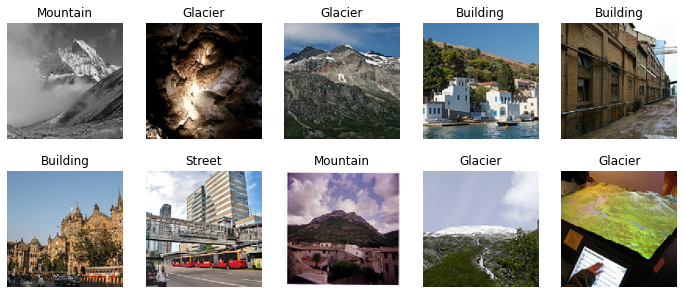

21626

In [36]:
plt.figure(figsize=(12,5))

for i in range(1,11):
    plt.subplot(2,5,i)
    plt.title(f'{train["scene"].values[index[i]]}')
    plt.imshow(train_imgs[index[i]])
    plt.axis('off')
plt.show()
gc.collect()

So, we can see that the third image can be both mountain and glacier but labeled as glacier. Or, the 7th image of street has a large proportion of building. So, we drop these images and make a new data set for training.

In [37]:
new_imgs=np.delete(train_imgs,index,axis=0)
new_y=np.delete(y,index,axis=0)
print(new_imgs.shape)
print(new_y.shape)

(16707, 224, 224, 3)
(16707, 6)


So, now we get 16707 images on training set.

# Confusion matrix formation

In [13]:
def plot_confusion_matrix(y_true, y_pred, classes, title, cmap=plt.cm.Greens):
   
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           )
    ax.set_title(title,fontsize=20)
    ax.set_xlabel('Predicted label',fontsize=15)
    ax.set_ylabel('True label',fontsize=15)
    plt.setp(ax.get_xticklabels(), rotation=0)

    fmt ='d'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    gc.collect()

# Splitting data into train and validation set

In [14]:
X_train, X_val, y_train, y_val = train_test_split(new_imgs, new_y, test_size=0.20, random_state=1)

In [40]:
train_generator = gen.flow(X_train, y_train,batch_size=BS)

# Using Resnet50 pretrained CNN model

In [16]:
from tensorflow.keras.applications.resnet50 import ResNet50
model=models.Sequential([
    layers.Input((224,224,3)),
    ResNet50(include_top=False),
    GlobalAveragePooling2D(),
    Dense(6, activation='softmax')
])

94773248/94765736 [==============================] - 11s 0us/step


In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

lr=0.0001
epoch=20
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
save = ModelCheckpoint('best.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model.compile(loss='categorical_crossentropy', 
              metrics=['accuracy'],
              optimizer=Adam(lr=lr,decay=lr/epoch))

In [19]:
history = model.fit_generator(train_generator, 
                    steps_per_epoch=len(X_train)//BS, 
                    validation_data=(X_val,y_val),
                    epochs=epoch,
                    callbacks=[earlyStopping,save])

Epoch 1/20
425/425 [==============================] - 3763s 9s/step - loss: 0.4966 - accuracy: 0.8218 - val_loss: 2.0304 - val_accuracy: 0.2413
Epoch 2/20
425/425 [==============================] - 8691s 20s/step - loss: 0.3461 - accuracy: 0.8741 - val_loss: 0.4998 - val_accuracy: 0.8377
Epoch 3/20
425/425 [==============================] - 32674s 77s/step - loss: 0.3073 - accuracy: 0.8887 - val_loss: 0.2373 - val_accuracy: 0.9225
Epoch 4/20
425/425 [==============================] - 3755s 9s/step - loss: 0.2774 - accuracy: 0.9022 - val_loss: 0.2164 - val_accuracy: 0.9293
Epoch 5/20
425/425 [==============================] - 4434s 10s/step - loss: 0.2576 - accuracy: 0.9019 - val_loss: 0.3398 - val_accuracy: 0.9046
Epoch 6/20
425/425 [==============================] - 4700s 11s/step - loss: 0.2430 - accuracy: 0.9121 - val_loss: 0.2371 - val_accuracy: 0.9281
Epoch 7/20
425/425 [==============================] - 4347s 10s/step - loss: 0.2323 - accuracy: 0.9147 - val_loss: 0.2480 - val_acc

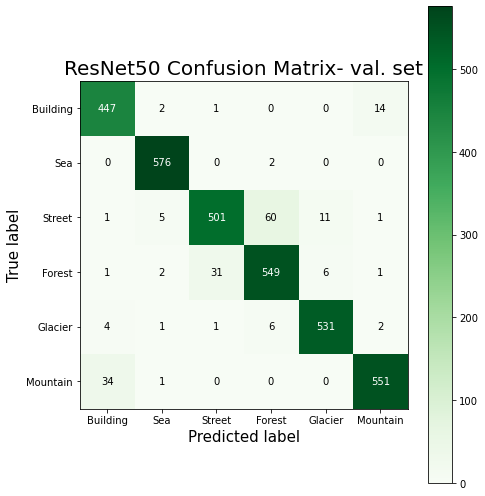

In [55]:
labels = list(train['scene'].unique())
true = np.argmax(y_val, axis=1)
best = load_model('best.hdf5')
valid_pred = np.argmax(best.predict(X_val), axis=1)
plot_confusion_matrix(true, valid_pred, classes=labels, title='ResNet50 Confusion Matrix- val. set')

In [18]:
print("Training accuracy: ",accuracy_score(np.argmax(y_train, axis=1),np.argmax(best.predict(X_train), axis=1)))
print("Validation accuracy: ",accuracy_score(true,valid_pred))

Training accuracy:  0.9426139282307184
Validation accuracy:  0.9292632814793073


In [23]:
sub=pd.read_csv('C:/Users/reya.sadhu/Downloads/sample.csv')
sub['label']=np.argmax(best.predict(test_imgs),axis=1)
sub.head()

,image_name,label
0,3.jpg,5
1,5.jpg,0
2,6.jpg,4
3,11.jpg,2
4,14.jpg,5


In [24]:
sub.to_csv('resnet50_imagenet.csv',index=False)

This gives a 93.1% accuracy on test set

# Fitting Xception pretrained model

In [27]:
from tensorflow.keras.applications.xception import Xception
model1=models.Sequential([
    layers.Input((224,224,3)),
    Xception(include_top=False),
    GlobalAveragePooling2D(),
    Dense(6, activation='softmax')
])

In [31]:
save1 = ModelCheckpoint('best_xception.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model1.compile(loss='categorical_crossentropy', 
              metrics=['accuracy'],
              optimizer=Adam(lr=lr,decay=lr/epoch))

In [32]:
history_xc = model1.fit_generator(train_generator, 
                    steps_per_epoch=len(X_train)//BS, 
                    validation_data=(X_val,y_val),
                    epochs=epoch,
                    callbacks=[earlyStopping,save1])

Epoch 1/20
425/425 [==============================] - 9781s 23s/step - loss: 0.4784 - accuracy: 0.8321 - val_loss: 0.2273 - val_accuracy: 0.9137
Epoch 2/20
425/425 [==============================] - 5975s 14s/step - loss: 0.3052 - accuracy: 0.8919 - val_loss: 0.1966 - val_accuracy: 0.9313
Epoch 3/20
425/425 [==============================] - 4443s 10s/step - loss: 0.2691 - accuracy: 0.9039 - val_loss: 0.2065 - val_accuracy: 0.9290
Epoch 4/20
425/425 [==============================] - 4405s 10s/step - loss: 0.2348 - accuracy: 0.9163 - val_loss: 0.2677 - val_accuracy: 0.9072
Epoch 5/20
425/425 [==============================] - 4420s 10s/step - loss: 0.2168 - accuracy: 0.9222 - val_loss: 0.2069 - val_accuracy: 0.9290
Epoch 6/20
425/425 [==============================] - 4419s 10s/step - loss: 0.1879 - accuracy: 0.9300 - val_loss: 0.1937 - val_accuracy: 0.9351
Epoch 7/20
425/425 [==============================] - 4386s 10s/step - loss: 0.1791 - accuracy: 0.9353 - val_loss: 0.1900 - val_ac

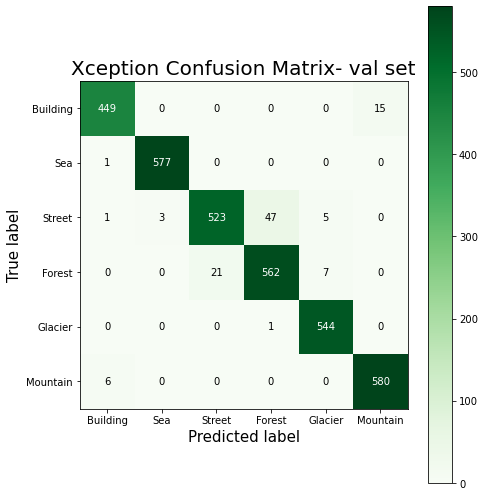

In [56]:
best=load_model('best_xception.hdf5')
valid_pred = np.argmax(best.predict(X_val), axis=1)
plot_confusion_matrix(true, valid_pred, classes=labels, title='Xception Confusion Matrix- val set')

In [19]:
print("Training accuracy: ",accuracy_score(np.argmax(y_train, axis=1),np.argmax(best.predict(X_train), axis=1)))
print("Validation accuracy: ",accuracy_score(true,valid_pred))

Training accuracy:  0.9708666617744184
Validation accuracy:  0.9424713824479014


In [33]:
sub['label']=np.argmax(best.predict(test_imgs),axis=1)
sub.head()

,image_name,label
0,3.jpg,5
1,5.jpg,0
2,6.jpg,4
3,11.jpg,2
4,14.jpg,5


In [34]:
sub.to_csv('xception_imagenet.csv',index=False)

 This gives a 95.25% accuracy on test set.

# Fitting InceptionResNetv2 pretrained model

In [62]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
model2=models.Sequential([
    layers.Input((224,224,3)),
    InceptionResNetV2(include_top=False),
    GlobalAveragePooling2D(),
    Dense(6, activation='softmax')
])
save2 = ModelCheckpoint('best_inception.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model2.compile(loss='categorical_crossentropy', 
              metrics=['accuracy'],
              optimizer=Adam(lr=lr,decay=lr/epoch))

219062272/219055592 [==============================] - 47s 0us/step


In [63]:
history_inc = model2.fit_generator(train_generator, 
                    steps_per_epoch=len(X_train)//BS, 
                    validation_data=(X_val,y_val),
                    epochs=epoch,
                    callbacks=[earlyStopping,save2])

Epoch 1/20
425/425 [==============================] - 5209s 12s/step - loss: 0.4973 - accuracy: 0.8181 - val_loss: 0.3020 - val_accuracy: 0.8932
Epoch 2/20
425/425 [==============================] - 5218s 12s/step - loss: 0.3359 - accuracy: 0.8771 - val_loss: 0.2905 - val_accuracy: 0.8943
Epoch 3/20
425/425 [==============================] - 6293s 15s/step - loss: 0.2822 - accuracy: 0.8967 - val_loss: 0.2458 - val_accuracy: 0.9178
Epoch 4/20
425/425 [==============================] - 5408s 13s/step - loss: 0.2579 - accuracy: 0.9045 - val_loss: 0.2365 - val_accuracy: 0.9190
Epoch 5/20
425/425 [==============================] - 5203s 12s/step - loss: 0.2512 - accuracy: 0.9074 - val_loss: 0.2106 - val_accuracy: 0.9266
Epoch 6/20
425/425 [==============================] - 5229s 12s/step - loss: 0.2297 - accuracy: 0.9141 - val_loss: 0.2528 - val_accuracy: 0.9208
Epoch 7/20
425/425 [==============================] - 5205s 12s/step - loss: 0.2234 - accuracy: 0.9169 - val_loss: 0.3816 - val_ac

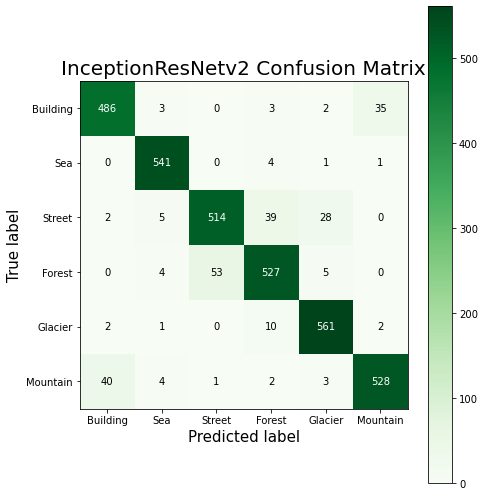

In [23]:
best=load_model('best_inception.hdf5')
valid_pred = np.argmax(best.predict(X_val), axis=1)
plot_confusion_matrix(true, valid_pred, classes=labels, title='InceptionResNetv2 Confusion Matrix')

In [24]:
print("Training accuracy: ",accuracy_score(np.argmax(y_train, axis=1),np.argmax(best.predict(X_train), axis=1)))
print("Validation accuracy: ",accuracy_score(true,valid_pred))

Training accuracy:  0.9600058706978792
Validation accuracy:  0.9266216612855885


In [64]:
sub=pd.read_csv('C:/Users/reya.sadhu/Downloads/sample.csv')
sub['label']=np.argmax(best.predict(test_imgs),axis=1)
sub.head()

,image_name,label
0,3.jpg,5
1,5.jpg,0
2,6.jpg,4
3,11.jpg,4
4,14.jpg,5


In [65]:
sub.to_csv('inception_imagenet.csv',index=False)

This gives a 94.06% accuracy on test set.

## Ensembling these 3 models gives a 95.79% accuracy. 

Some intermediate submission were also done, using the whole training images, with different image size, batch size and learning rates. We take different ensemble of them, the best one gives a 96.75% accuracy on test set.

In [31]:
all_submissions = os.listdir('All submissions')

In [32]:
all_submissions

['all_aug.csv',
 'inception_imagenet.csv',
 'inc_end_model.csv',
 'inc_xcep_aug.csv',
 'resnet50_imagenet.csv',
 'xception_imagenet.csv',
 'xcep_end_model.csv']

In [34]:
t=pd.read_csv('C:/Users/reya.sadhu/Downloads/test.csv')
t.set_index('image_name', inplace=True)
for sub in all_submissions:
    df = pd.read_csv('All submissions/'+sub)
    df.set_index('image_name', inplace=True)
    t[sub] = df['label']

In [35]:
final_submission = t.mode(axis=1,dropna=True).drop(columns=[1])
final_submission.rename(columns={0: 'label'}, inplace=True)

In [36]:
final_submission['label']=final_submission['label'].astype('int')

In [37]:
final_submission

,label
image_name,
3.jpg,5
5.jpg,0
6.jpg,4
11.jpg,2
14.jpg,5
...,...
24326.jpg,1
24327.jpg,2
24330.jpg,2


In [38]:
final_submission.to_csv('Ultimate.csv', index=True)